In [1]:
# Importing the necessary libraries
import torch
from torch import optim, utils, tensor, nn

import matplotlib.pyplot as plt
from getdist import plots, MCSamples

from Network import Generator, Discriminator
from Signal_Generator import *

from tqdm import tqdm

# Setting the device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
# Defining the hyperparameters
datasize = 16000
num_sources = 1
noise_amplitude = 0

num_latent_variables = 20
learning_rate = 1e-5
weight_clip = 0.1

d_loss_threshold = -0.1
g_loss_threshold = -0.3
threshold_adjustment = 0.025
max_steps = 300

num_epochs = 1500

In [3]:
# Defining the distribution for amplitude and angular frequency
def amp_distribution(size):
    """
    Amplitude distribution using uniform distribution.
    """
    return np.random.uniform(6, 14, size=size)

def omega_distribution(size):
    """
    Angular frequency distribution using uniform distribution.
    """
    return np.random.uniform(0.33, 0.67, size=size)

In [4]:
# Defining the WGAN traning class
class WGAN(nn.Module):
    def __init__(self, num_latent_variables, lr, weight_clip):
        super(WGAN, self).__init__()
        self.num_latent_variables = num_latent_variables
        self.lr = lr
        self.weight_clip = weight_clip

        # Networks
        self.generator = Generator(in_channels=1, num_latent_variables=num_latent_variables, length=len(signal), num_parameters=len(params)).to(device)
        self.discriminator = Discriminator(input_channels=1, length=len(signal), num_parameters=len(params)).to(device)

        # Optimizers
        self.optimizer_g = optim.Adam(self.generator.parameters(), lr=self.lr)
        self.optimizer_d = optim.Adam(self.discriminator.parameters(), lr=self.lr)

    def wasserstein_loss(self, output_d, y):
        return torch.mean(output_d * y)
    
    def train_generator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, fake_params)
        real_output = self.discriminator(signal_tensor, params_tensor)
        g_loss = -torch.mean(fake_output)
        d_loss = -(torch.mean(real_output) - torch.mean(fake_output))

        self.optimizer_g.zero_grad()
        g_loss.backward()
        self.optimizer_g.step()

        return g_loss.item(), d_loss.item()
    
    def train_discriminator(self, signal_tensor, params_tensor, z):
        fake_params = self.generator(signal_tensor, z)
        fake_output = self.discriminator(signal_tensor, fake_params)
        real_output = self.discriminator(signal_tensor, params_tensor)
        g_loss = -torch.mean(fake_output)
        d_loss = -(torch.mean(real_output) - torch.mean(fake_output))

        self.optimizer_d.zero_grad()
        d_loss.backward()
        self.optimizer_d.step()

        # Weight clipping
        for p in self.discriminator.parameters():
            p.data.clamp_(-self.weight_clip, self.weight_clip)

        return g_loss.item(), d_loss.item()

In [5]:
generator = torch.load('generator_model.pt')
Discriminator = torch.load('discriminator_model.pt')

generator.eval()

Generator(
  (init_conv): Conv1d(1, 64, kernel_size=(3,), stride=(1,), padding=(1,))
  (init_relu): LeakyReLU(negative_slope=0.2)
  (res_block_no_norm): ResBlock(
    (conv1): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (conv2): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (conv3): Conv1d(64, 64, kernel_size=(3,), stride=(1,), padding=(1,))
    (leaky_relu): LeakyReLU(negative_slope=0.2)
  )
  (down1): Conditional_Down(
    (conv): Conv1d(64, 128, kernel_size=(3,), stride=(1,), padding=(1,))
    (relu): LeakyReLU(negative_slope=0.2)
    (avg_pool): AvgPool1d(kernel_size=(2,), stride=(2,), padding=(0,))
    (res_block): Conditional_ResBlock(
      (conv1): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (conv3): Conv1d(128, 128, kernel_size=(3,), stride=(1,), padding=(1,))
      (leaky_relu): LeakyReLU(negative_slope=0.2)
      (process1): CIN(
        (inst_norm): InstanceNorm1d(

[14.55035423237964, 0.35785662386709155, 5.726273338910865]
[array([14.192477 ,  0.3813014,  5.7689176], dtype=float32), array([14.07546   ,  0.37462223,  5.7223325 ], dtype=float32), array([14.05315 ,  0.363322,  5.747825], dtype=float32), array([14.066141  ,  0.36669075,  5.728736  ], dtype=float32), array([14.012817  ,  0.35746258,  5.751736  ], dtype=float32), array([14.0931425,  0.3590708,  5.8013496], dtype=float32), array([14.035141  ,  0.36213875,  5.7982874 ], dtype=float32), array([14.12834  ,  0.3581349,  5.883304 ], dtype=float32), array([13.995339  ,  0.35885662,  5.7693377 ], dtype=float32), array([14.066261  ,  0.37594482,  5.747001  ], dtype=float32), array([14.127902 ,  0.3508273,  5.681236 ], dtype=float32), array([14.045588 ,  0.3526048,  5.7802525], dtype=float32), array([14.1501255 ,  0.36164474,  5.8627324 ], dtype=float32), array([14.079699 ,  0.3873189,  5.742281 ], dtype=float32), array([14.008209  ,  0.37233293,  5.725045  ], dtype=float32), array([14.062385  

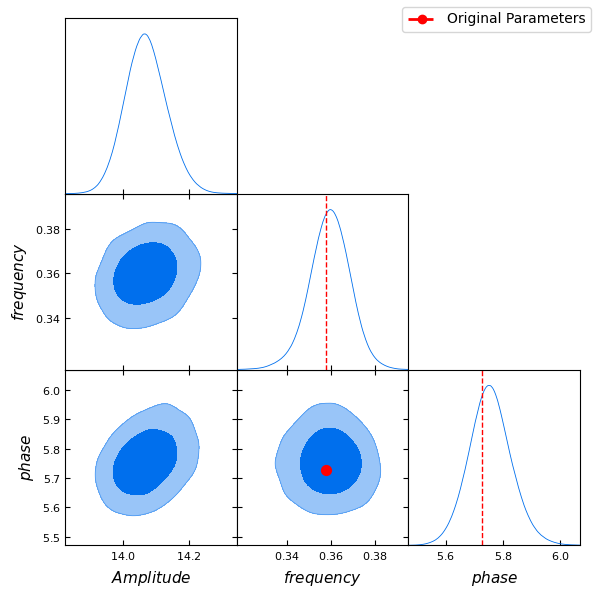

In [10]:
generated_params_list = []

TS = Signal_Generator(num_sources=1, noise_amplitude=0)
test_data = TS.generating_signal()
params = TS.printing_parameters()

input_signal = test_data['Signal'].values
input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

for i in range(10000):
    with torch.no_grad():
        z = torch.randn(1, num_latent_variables, 1).to(device)
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    generated_params_list.append(generated_params)

print(params)
print(generated_params_list)

generated_params_df = pd.DataFrame(generated_params_list, columns=['Amplitude', 'Frequency', 'Phase'])

names = ["A","omega","theta"]
labels =  ["Amplitude","frequency","phase"]

generated_params_samples = MCSamples(samples=generated_params_df.values, names=names, labels=labels, settings={'ignore_rows': 1000})
generated_params_samples.updateSettings({'fine_bins_2D': 1048})

g = plots.get_subplot_plotter()

g.triangle_plot([generated_params_samples], filled=True)

axes = g.subplots

for i in range(len(names)):
    for j in range(i+1, len(names)):
        ax = axes[j, i]
        if ax is not None:
            ax.scatter(params[i], params[j], color='red', marker='o', s=50)

for i in range(len(names)):
    ax = axes[i, i]
    if ax is not None:
        ax.axvline(params[i], linestyle='--', color='red', lw=1)

handles = [plt.Line2D([0], [0], color='red', lw=2, linestyle='--', marker='o')]
labels = ['Original Parameters']
g.fig.legend(handles, labels, loc='upper right')

plt.show()

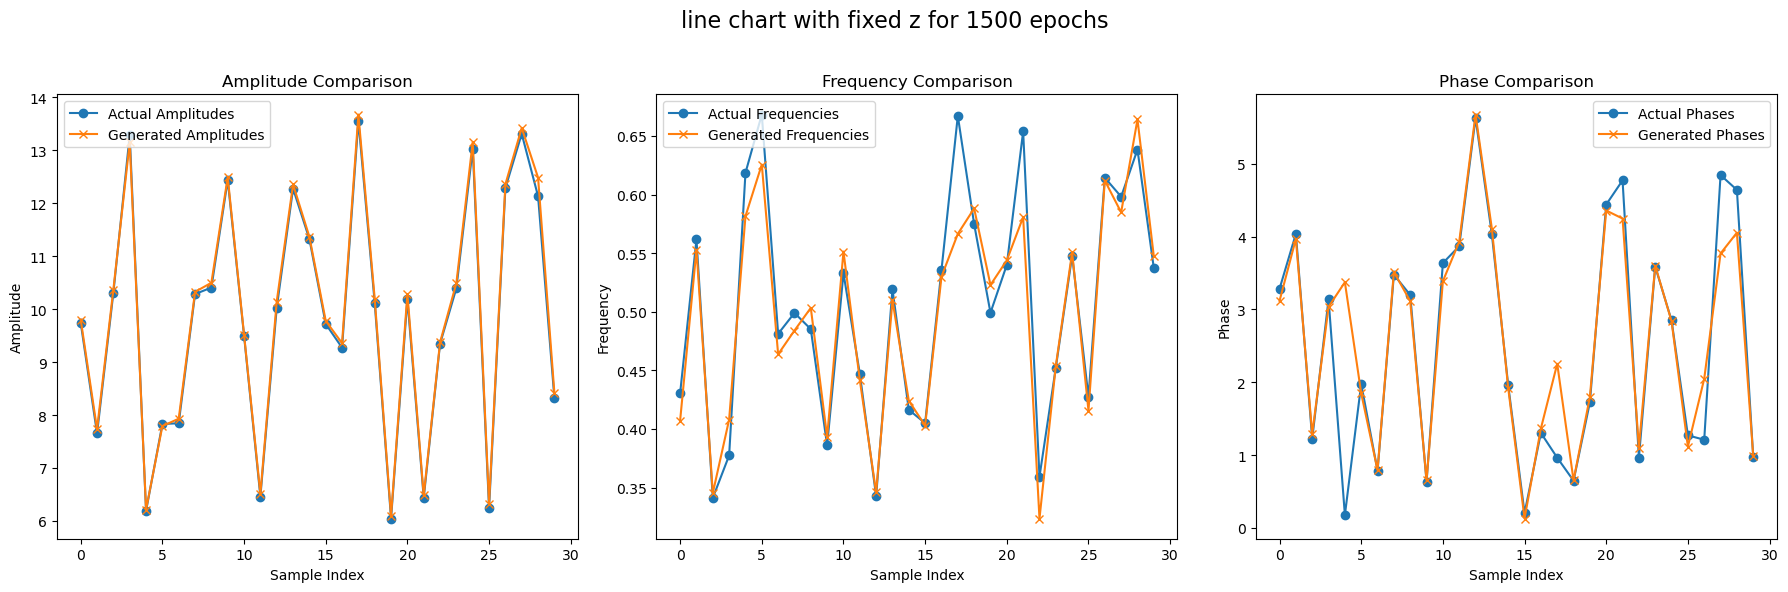

In [8]:
params_list = []
generated_params_list = []

test_times = 30
for i in range(test_times):
    TS = Signal_Generator(num_sources=1, noise_amplitude=0, amp_distribution_func=amp_distribution, omega_distribution_func=omega_distribution)
    test_data = TS.generating_signal()
    params = TS.printing_parameters()

    input_signal = test_data['Signal'].values
    input_signal_tensor = torch.tensor(input_signal, dtype=torch.float).unsqueeze(0).unsqueeze(0).to(device)

    with torch.no_grad():
        z = torch.randn(1, num_latent_variables, 1).to(device)
        generated_params = generator(input_signal_tensor, z).squeeze().cpu().numpy()

    params_list.append(params)
    generated_params_list.append(generated_params)

    #print(params)
    #print(generated_params)

actual_amplitudes = [params[0] for params in params_list]
actual_frequencies = [params[1] for params in params_list]
actual_phases = [params[2] for params in params_list]

generated_amplitudes = [gen_params[0] for gen_params in generated_params_list]
generated_frequencies = [gen_params[1] for gen_params in generated_params_list]
generated_phases = [gen_params[2] for gen_params in generated_params_list]

plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.plot(range(test_times), actual_amplitudes, 'o-', label='Actual Amplitudes')
plt.plot(range(test_times), generated_amplitudes, 'x-', label='Generated Amplitudes')
plt.xlabel('Sample Index')
plt.ylabel('Amplitude')
plt.title('Amplitude Comparison')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(range(test_times), actual_frequencies, 'o-', label='Actual Frequencies')
plt.plot(range(test_times), generated_frequencies, 'x-', label='Generated Frequencies')
plt.xlabel('Sample Index')
plt.ylabel('Frequency')
plt.title('Frequency Comparison')
plt.legend()

plt.subplot(1, 3, 3)
plt.plot(range(test_times), actual_phases, 'o-', label='Actual Phases')
plt.plot(range(test_times), generated_phases, 'x-', label='Generated Phases')
plt.xlabel('Sample Index')
plt.ylabel('Phase')
plt.title('Phase Comparison')
plt.legend()

plt.suptitle(f'line chart with fixed z for {num_epochs} epochs', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()